## Purpose: Simulating multivariate distributions and inducing correlations

### Update: 01/25/2017:

1. This process has the problem of creating ranks with replacement, and so ultimately we end up dropping some draws
2. Maybe a simulatenous sorting is the best way?

In [121]:
require(VineCopula)
require(copula)
require(ggplot2)
require(ggExtra)
require(gridExtra)
require(dplyr)
require(MASS)

## Resizing notebook plot space
options(repr.plot.width=8, repr.plot.height=5)

Loading required package: MASS

Attaching package: ‘MASS’

The following object is masked from ‘package:dplyr’:

    select



### Simulate (independent) standard normal distributions

In [2]:
# Distribution parameters
N = 10000
mu = 0
sigma = 1

# The correlation we want to induce 
rho = 0.7

In [3]:
set.seed(123)
X <- rnorm(N, mu, sigma)
Y <- rnorm(N, mu, sigma)
Z <- rnorm(N, mu, sigma)

head(data.frame(index = c(1:N),X= X,Y= Y,Z= Z))

index X           Y          Z         
1 1     -0.56047565  2.3707252 -0.8362967
2 2     -0.23017749 -0.1668120 -0.2205730
3 3      1.55870831  0.9269614 -2.1035148
4 4      0.07050839 -0.5681517 -1.6678075
5 5      0.12928774  0.2250901 -1.0979629
6 6      1.71506499  1.1319859 -1.6656212

## Use a copula to jointy correlate X, Y and Z, and create newly sorted variables

#### This function takes a correlation parameter (vector) and the number of draws to simulate, and returns a data frame with the index of the draws to arrange by in order to achieve the specified correlation, and also the sorted data using those indices

In [10]:
## Checking the original existing correlation
cor(cbind(X, Y, Z), method = "spearman")

X          Y            Z           
X 1.00000000 0.0103485226 0.0169983371
Y 0.01034852 1.0000000000 0.0001936581
Z 0.01699834 0.0001936581 1.0000000000

In [9]:
## Use a 0.7 cross-correlation  
corr_vector <- c(0.7, 0.7, 0.7)

### NOTE: the normalCopula function takes a vector of parameters, such that 
## if corr <- c(A, B, C), then the number A corresponds to the correlation b/w the first two variables of data, 
## B for corr b/w second and third, C for corr b/w third and first

### Creating a function which will take a N dim data frame and sort.... hope it works

In [91]:
create_corr_indices <- function(corr, draws, data) {

    ## How many variables are we dealing with?
        dim = length(corr)
    
    ## Break if number of element in correlation vector is not equal to the number of columns
        if (dim > 1) {
            stopifnot(dim == dim(data)[2])
            str <- "un"
            dim_c <- dim
        }
        if (dim == 1) {
            str <- "un"
            dim_c <- 2
        }
        
    
        print(cop_object_1 <- normalCopula(param = corr, dim = dim_c, dispstr = paste0(str)))
        cop_draws_1 <- rCopula(n = draws, copula = cop_object_1)
 
    ## Convert the bivariate distribution into indices (multiply by 1000, and round to integers)
        cop_indices_1 <- data.frame(ceiling(draws*cop_draws_1))
  
    # Bounding if any value is above the highest number
        for(i in 1:dim_c) {
          cop_indices_1[,i] <- ifelse(cop_indices_1[,i]>draws, draws, cop_indices_1[,i])
        }
    
    ## Let the first column be the baseline index in the copula; sort the baseline column
        cop_indices_1 <- arrange(cop_indices_1, cop_indices_1[,1])
    
    #### Take our marginals we previously made, and arrange them separately
        sorted_data <- list()
        for(i in c(1:dim_c)) {
            sorted_data[[i]] <-sort(data[,i])
        }
        sorted_data_df <- as.data.frame(sorted_data)
        colnames(sorted_data_df) <- paste0("var_",c(1:dim_c))

#         X_sorted <- sort(data[,1])
#         Y_sorted <- sort(data[,2])
#         Z_sorted <- sort(data[,3])

    #### Loop over the copula index data frame and create a joint distribution of X and Y with those indices
        joint_sorted <- data.frame()

        for(i in c(1:draws)) {
          for(j in c(1:dim_c)) {
            joint_sorted[i,j] = sorted_data_df[cop_indices_1[i,j], j]
            }
        }
    
    
    print("New Spearman Correlation Matrix:")
    print(cor(joint_sorted , method = "spearman"))
    
    return(list(copula_index = cop_indices_1, data = joint_sorted ))
}

### Use this function on the joint 3-D data of marginals (X, Y, Z)

In [97]:
tri_copula <- create_corr_indices(corr_vector, draws = N, data = cbind(X, Y, Z))
XYZ_copula_indices <- tri_copula$copula_index
XYZ_all_joint <- tri_copula$data
colnames(XYZ_copula_indices) <- c("X_index", "Y_index", "Z_index")
colnames(XYZ_all_joint) <- c("X_sorted", "Y_sorted", "Z_sorted")
head(cbind(XYZ_copula_indices,XYZ_all_joint))

Normal copula, dim. d = 3 
Dimension:  3 
Parameters:
  rho.1   = 0.7
  rho.2   = 0.7
  rho.3   = 0.7
dispstr:  un 
[1] "New Spearman Correlation Matrix:"
          V1        V2        V3
V1 1.0000000 0.6822434 0.6792089
V2 0.6822434 1.0000000 0.6822313
V3 0.6792089 0.6822313 1.0000000


X_index Y_index Z_index X_sorted  Y_sorted   Z_sorted 
1 1        450    149     -3.845320 -1.6966194 -2.178121
2 4         29     75     -3.402024 -2.7837200 -2.411279
3 4         70     47     -3.402024 -2.4249816 -2.529801
4 5        747     69     -3.289376 -1.4633217 -2.445715
5 6       1655    116     -3.262149 -0.9701652 -2.260305
6 7        151      9     -3.189186 -2.1677139 -2.970882

#### Test Case: Set the correlation matrix to be all 1s

In [107]:
perfect_copula <- create_corr_indices(c(1,1,1), draws = N, data = cbind(X, Y, Z))
perfect_XYZ_copula_indices <- perfect_copula$copula_index
perfect_XYZ_all_joint <- perfect_copula$data
colnames(perfect_XYZ_copula_indices) <- c("X_index", "Y_index", "Z_index")
colnames(perfect_XYZ_all_joint) <- c("X_sorted", "Y_sorted", "Z_sorted")
head(cbind(perfect_XYZ_copula_indices,perfect_XYZ_all_joint))

Normal copula, dim. d = 3 
Dimension:  3 
Parameters:
  rho.1   = 1
  rho.2   = 1
  rho.3   = 1
dispstr:  un 
[1] "New Spearman Correlation Matrix:"
   V1 V2 V3
V1  1  1  1
V2  1  1  1
V3  1  1  1


X_index Y_index Z_index X_sorted  Y_sorted  Z_sorted 
1 2       2       2       -3.467490 -3.418076 -3.497287
2 4       4       4       -3.402024 -3.296524 -3.279983
3 4       4       4       -3.402024 -3.296524 -3.279983
4 5       5       5       -3.289376 -3.264361 -3.274385
5 6       6       6       -3.262149 -3.244513 -3.253787
6 8       8       8       -3.137385 -3.106484 -3.141838

### Challenge: Use this beautiful and somehow working function, and induce pairwise correlations (X,Y), and (Y,Z), and see how (X,Z) looks like after

##### X,Y

In [98]:
XY_copula <- create_corr_indices(0.7, draws = N, data = cbind(X, Y))
XY_copula_indices <- XY_copula$copula_index
XY_all_joint <- XY_copula$data
colnames(XY_copula_indices) <- c("X_index", "Y_index")
colnames(XY_all_joint) <- c("X_sorted", "Y_sorted")
head(cbind(XY_copula_indices,XY_all_joint))

Normal copula, dim. d = 2 
Dimension:  2 
Parameters:
  rho.1   = 0.7
[1] "New Spearman Correlation Matrix:"
          V1        V2
V1 1.0000000 0.6833022
V2 0.6833022 1.0000000


X_index Y_index X_sorted  Y_sorted 
1 1       417     -3.845320 -1.743059
2 1       117     -3.845320 -2.264699
3 2       127     -3.467490 -2.229312
4 2       561     -3.467490 -1.604969
5 2        41     -3.467490 -2.633920
6 3       326     -3.413788 -1.850042

##### Y,X

In [115]:
YX_copula <- create_corr_indices(0.7, draws = N, data = cbind( Y, X))
YX_copula_indices <- YX_copula$copula_index
YX_all_joint <- YX_copula$data
colnames(YX_copula_indices) <- c( "Y_index","X_index")
colnames(YX_all_joint) <- c("Y_sorted", "X_sorted")
head(cbind(YX_copula_indices,YX_all_joint))

Normal copula, dim. d = 2 
Dimension:  2 
Parameters:
  rho.1   = 0.7
[1] "New Spearman Correlation Matrix:"
          V1        V2
V1 1.0000000 0.6806532
V2 0.6806532 1.0000000


Y_index X_index Y_sorted  X_sorted 
1 1        34     -3.488734 -2.667958
2 2        10     -3.418076 -3.058123
3 4        23     -3.296524 -2.839376
4 6       116     -3.244513 -2.249051
5 7        78     -3.125199 -2.389744
6 8       197     -3.106484 -2.053247

## Notations:

sort(A) = take the raw data and sort ascending   
csort(A) = data sorted using Copula, might have dups

### Look at the following combos of correlations: (X,Y), (sort(X), csort(Y)), (csort(X),sort(Y)), (csort(X), csort(Y))

#### (1) Using the XY sorting (where X was used as baseline)

In [114]:
## X,Y
print("X,Y")
cor(cbind(X,Y), method="spearman")

## sort(X), sort(Y)
print("sort(X),sort(Y)")
cor(cbind(sort(X),sort(Y)), method="spearman")

## sort(X),csort(Y)
print("sort(X),csort(Y)")
cor(cbind(sort(X),XY_all_joint$Y_sorted), method="spearman")

## csort(X), sort(Y)
print("csort(X),sort(Y)")
cor(cbind(XY_all_joint$X_sorted,sort(Y)), method="spearman")

## csort(X), csort(Y)
print("csort(X),csort(Y)")
cor(cbind(XY_all_joint$X_sorted,XY_all_joint$Y_sorted), method="spearman")

[1] "X,Y"


X          Y         
X 1.00000000 0.01034852
Y 0.01034852 1.00000000

[1] "sort(X),sort(Y)"


[,1] [,2]
[1,] 1    1   
[2,] 1    1

[1] "sort(X),csort(Y)"


[,1]      [,2]     
[1,] 1.0000000 0.6833007
[2,] 0.6833007 1.0000000

[1] "csort(X),sort(Y)"


[,1] [,2]
[1,] 1    1   
[2,] 1    1

[1] "csort(X),csort(Y)"


[,1]      [,2]     
[1,] 1.0000000 0.6833022
[2,] 0.6833022 1.0000000

#### (2) Using the YX sorting (where Y was used as baseline)

In [116]:
## X,Y
print("X,Y")
cor(cbind(X,Y), method="spearman")

## sort(X), sort(Y)
print("sort(X),sort(Y)")
cor(cbind(sort(X),sort(Y)), method="spearman")

## sort(X),csort(Y)
print("sort(X),csort(Y)")
cor(cbind(sort(X),YX_all_joint$Y_sorted), method="spearman")

## csort(X), sort(Y)
print("csort(X),sort(Y)")
cor(cbind(YX_all_joint$X_sorted,sort(Y)), method="spearman")

## csort(X), csort(Y)
print("csort(X),csort(Y)")
cor(cbind(YX_all_joint$X_sorted,YX_all_joint$Y_sorted), method="spearman")

[1] "X,Y"


X          Y         
X 1.00000000 0.01034852
Y 0.01034852 1.00000000

[1] "sort(X),sort(Y)"


[,1] [,2]
[1,] 1    1   
[2,] 1    1

[1] "sort(X),csort(Y)"


[,1] [,2]
[1,] 1    1   
[2,] 1    1

[1] "csort(X),sort(Y)"


[,1]      [,2]     
[1,] 1.0000000 0.6806507
[2,] 0.6806507 1.0000000

[1] "csort(X),csort(Y)"


[,1]      [,2]     
[1,] 1.0000000 0.6806532
[2,] 0.6806532 1.0000000

### Woah.. If we just take the original X vector, sort it, and then look at its Spearman corr against the copula-sorted Y, we get a corr close to rho!

##### Y,Z

In [99]:
YZ_copula <- create_corr_indices(0.7, draws = N, data = cbind(Y, Z))
YZ_copula_indices <- YZ_copula$copula_index
YZ_all_joint <- YZ_copula$data
colnames(YZ_copula_indices) <- c("Y_index", "Z_index")
colnames(YZ_all_joint) <- c("Y_sorted", "Z_sorted")
head(cbind(YZ_copula_indices,YZ_all_joint))

Normal copula, dim. d = 2 
Dimension:  2 
Parameters:
  rho.1   = 0.7
[1] "New Spearman Correlation Matrix:"
          V1        V2
V1 1.0000000 0.6925113
V2 0.6925113 1.0000000


Y_index Z_index Y_sorted  Z_sorted 
1 1       184     -3.488734 -2.089678
2 1        48     -3.488734 -2.529683
3 2         1     -3.418076 -3.545884
4 5       238     -3.264361 -1.966477
5 6        29     -3.244513 -2.699319
6 7       598     -3.125199 -1.565163

### Neal's function for ordering draws (MUCH BETTER! USE THIS!)
https://github.com/nmmarquez/re_simulations/blob/master/demographic_variance/cop_example.R

In [117]:
cop_sort_data <- function(X, corr){
  if(length(corr) == 1){
    corr <- matrix(data=corr, nrow=ncol(X), ncol=ncol(X))
    diag(corr) <- 1
  }
  mvdat <- mvrnorm(n=nrow(X), mu=0 * 1:ncol(X), Sigma=corr, empirical=T)
  ranks <- apply(mvdat, 2, rank, ties.method="first")
  sorted_X <- apply(X, 2, sort)
  sapply(1:ncol(X), function(x) sorted_X[,x][ranks[,x]])
}

In [122]:
new_data <- cop_sort_data(cbind(X, Y, Z), 0.7)
cor(new_data, method="spearman")

[,1]      [,2]      [,3]     
[1,] 1.0000000 0.6831090 0.6855308
[2,] 0.6831090 1.0000000 0.6838861
[3,] 0.6855308 0.6838861 1.0000000

### Plots are always helpful

#### Plots of pairwise sorts

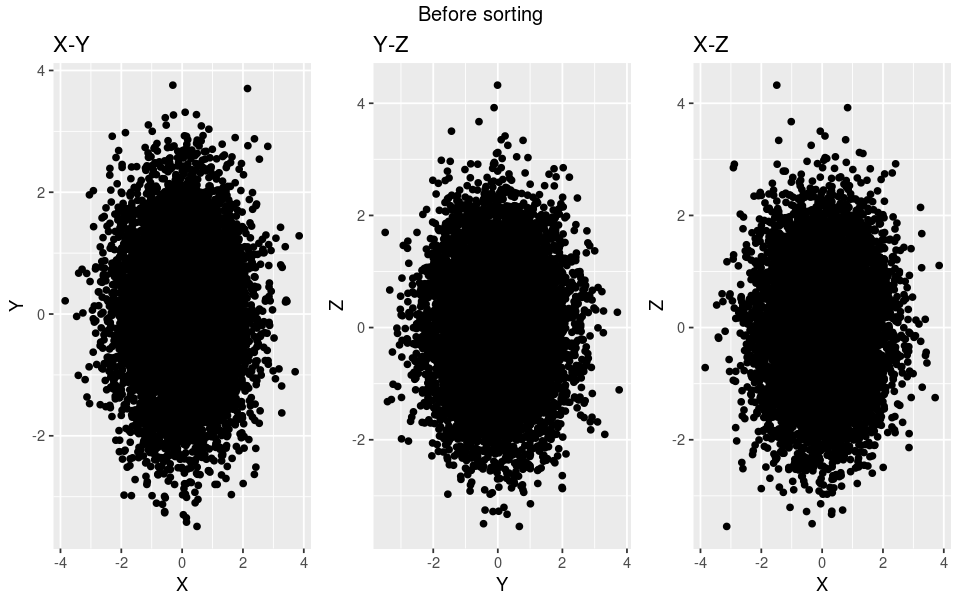

In [94]:
XY_pre<-ggplot(data=data.frame(cbind(X,Y))) + geom_point(aes(x=X,y=Y)) + ggtitle("X-Y")
YZ_pre<-ggplot(data=data.frame(cbind(Z,Y))) + geom_point(aes(x=Y,y=Z)) + ggtitle("Y-Z")
XZ_pre<-ggplot(data=data.frame(cbind(X,Z))) + geom_point(aes(x=X,y=Z)) + ggtitle("X-Z")

grid.arrange(XY_pre, YZ_pre, XZ_pre, nrow=1, top = "Before sorting")

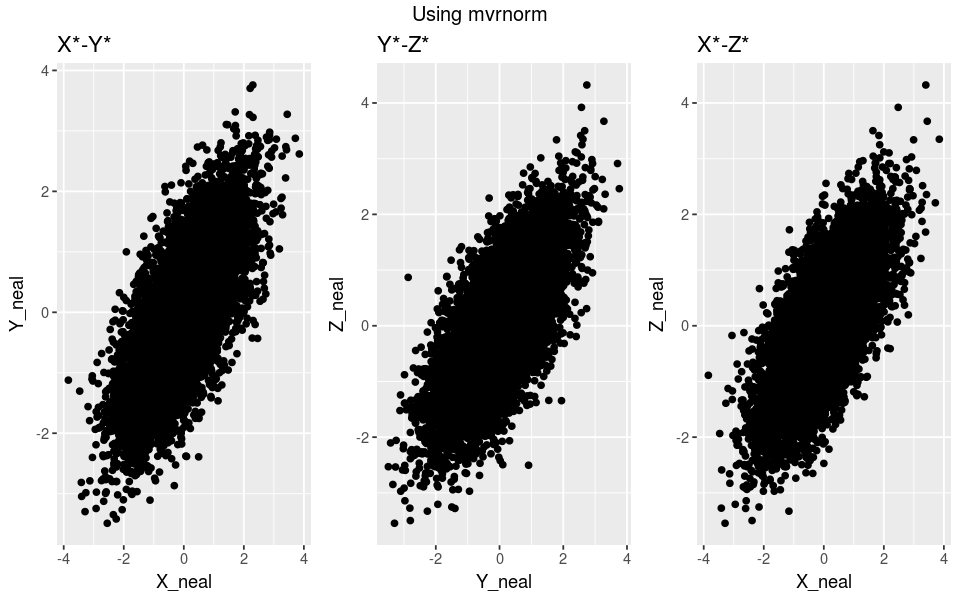

In [126]:
new_data <- data.frame(new_data)
colnames(new_data) <- c("X_neal", "Y_neal", "Z_neal")
XY_tri_post2<-ggplot(data=new_data ) + geom_point(aes(x=X_neal,y=Y_neal)) + ggtitle("X*-Y*")
YZ_tri_post2<-ggplot(data=new_data ) + geom_point(aes(x=Y_neal,y=Z_neal)) + ggtitle("Y*-Z*")
XZ_tri_post2<-ggplot(data=new_data ) + geom_point(aes(x=X_neal,y=Z_neal)) + ggtitle("X*-Z*")

grid.arrange(XY_tri_post2, YZ_tri_post2, XZ_tri_post2, nrow=1, top = "Using mvrnorm")

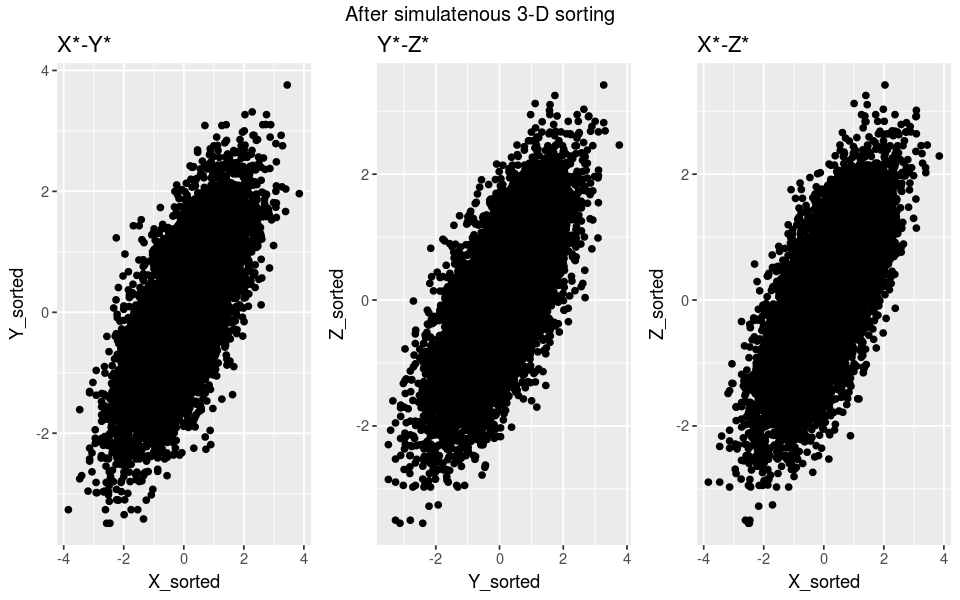

In [96]:
XY_tri_post<-ggplot(data=XYZ_all_joint ) + geom_point(aes(x=X_sorted,y=Y_sorted)) + ggtitle("X*-Y*")
YZ_tri_post<-ggplot(data=XYZ_all_joint ) + geom_point(aes(x=Y_sorted,y=Z_sorted)) + ggtitle("Y*-Z*")
XZ_tri_post<-ggplot(data=XYZ_all_joint ) + geom_point(aes(x=X_sorted,y=Z_sorted)) + ggtitle("X*-Z*")

grid.arrange(XY_tri_post, YZ_tri_post, XZ_tri_post, nrow=1, top = "After simulatenous 3-D sorting")